In [13]:
import jax
import jax.numpy as jnp
from functools import partial
import numpy as np
import time

from stance_leg_controller import ForceStanceLegController

from quadruped_jax import QuadrupedQPProjector

import matplotlib.pyplot as plt

#jax.config.update("jax_enable_x64", True)

In [14]:
num_batch=1  # Increased batch size to demonstrate batching
maxiter=500
rho=1
desired_speed=(0.0, 0.0)
desired_twisting_speed=0.0
desired_body_height=0.5
body_mass=30.0
body_inertia=(1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 1.0)
num_legs=4
friction_coeff=0.2
timestep=0.05
horizon=10
foot_x=0.2
foot_y=0.2
foot_z=-desired_body_height

In [15]:
# Initialize the projector with organized parameters
projector = QuadrupedQPProjector(
    num_batch=num_batch,
    maxiter=maxiter,
    rho=rho,
    desired_speed=desired_speed,
    desired_twisting_speed=desired_twisting_speed,
    desired_body_height=desired_body_height,
    body_mass=body_mass,
    body_inertia=body_inertia,
    num_legs=num_legs,
    friction_coeff=friction_coeff,
    timestep=timestep,
    horizon=horizon,
    foot_x=foot_x,
    foot_y=foot_y,
    foot_z=foot_z
)


    

self.num_total_constraints 240


In [16]:
# Print problem information
projector.print_problem_info()

# Sample batched initial guess
key = jax.random.PRNGKey(42)


lamda_init = jnp.zeros((projector.num_batch, projector.nvar))

#print(f"Initial xi batch shape: {xi_init.shape}")
print(f"Initial lambda batch shape: {lamda_init.shape}")

xi_init = jnp.zeros((projector.num_batch, projector.nvar))
for i in range(projector.num_legs*projector.horizon):
        xi_init = xi_init.at[:, 3*i+2].set(body_mass * 9.81 / 4.0)

=== Quadruped QP Problem Information ===
H matrix shape: (120, 120)
g vector shape: (120,)
C matrix shape: (240, 120)
constraint limit vector shape: (240,)
Number of variables: 120
Number of constraints: 240
Batch size: 1
Max iterations: 500
ADMM penalty (rho): 1
Initial lambda batch shape: (1, 120)


In [17]:
force_input = -xi_init[:, :12]
print(f"Initial Force Input shape: {force_input.shape}")
print(f"Initial Force Input: {force_input[0]}")

Initial Force Input shape: (1, 12)
Initial Force Input: [ -0.     -0.    -73.575  -0.     -0.    -73.575  -0.     -0.    -73.575
  -0.     -0.    -73.575]


In [18]:
# Solve batched QP projection
start_time = time.time()
xi_proj, primal_residual, fixed_point_residual = projector.compute_qp_projection(xi_init, lamda_init)
solve_time = time.time() - start_time

cost.shape (120, 120)


In [19]:
print(f"\n=== Solution Results ===")
print(f"Projection time: {solve_time:.6f} seconds")
print(f"Projected xi batch shape: {xi_proj.shape}")
print(f"Final primal residual shape: {primal_residual[-1].shape}")
print(f"Final dual residual shape: {fixed_point_residual[-1].shape}")

# Display convergence statistics
primal_residual_np = np.array(primal_residual)
fixed_point_residual_np = np.array(fixed_point_residual)

print(f"\n=== Convergence Statistics ===")
print(f"Primal residual - Initial (mean): {np.mean(primal_residual_np[0]):.6f}, Final (mean): {np.mean(primal_residual_np[-1]):.6f}")
print(f"Dual residual - Initial (mean): {np.mean(fixed_point_residual_np[0]):.6f}, Final (mean): {np.mean(fixed_point_residual_np[-1]):.6f}")
print(f"Primal residual - Final (max): {np.max(primal_residual_np[-1]):.6f}")
print(f"Dual residual - Final (max): {np.max(fixed_point_residual_np[-1]):.6f}")

# Extract force outputs (first 12 elements as in original code) for all batches
force_output = -xi_proj[:, :12]
print(f"\n=== Force Output ===")
print(f"Projected forces batch shape: {force_output.shape}")
print(f"First batch projected forces: {force_output[0]}")

print("\nBatched Quadruped QP projection complete!")


=== Solution Results ===
Projection time: 0.210405 seconds
Projected xi batch shape: (1, 120)
Final primal residual shape: (1,)
Final dual residual shape: (1,)

=== Convergence Statistics ===
Primal residual - Initial (mean): 0.000000, Final (mean): 0.000000
Dual residual - Initial (mean): 38.023396, Final (mean): 0.005892
Primal residual - Final (max): 0.000000
Dual residual - Final (max): 0.005892

=== Force Output ===
Projected forces batch shape: (1, 12)
First batch projected forces: [ 4.2922478e-04  2.8496413e-04 -7.3570740e+01  4.2637589e-04
  2.8403036e-04 -7.3563248e+01  4.1967994e-04  2.9067093e-04
 -7.3565193e+01  4.3110800e-04  2.7064409e-04 -7.3559425e+01]

Batched Quadruped QP projection complete!


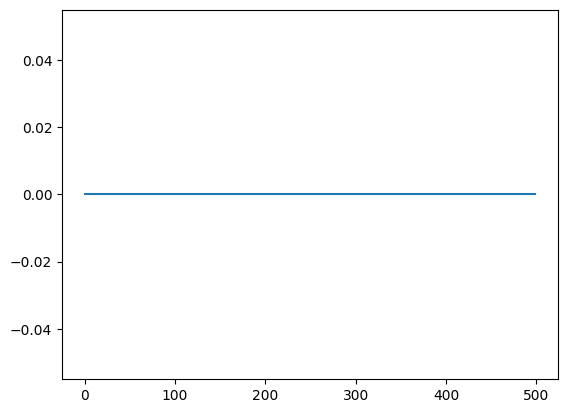

In [20]:
%matplotlib inline
plt.figure()
plt.plot(primal_residual)
plt.show()

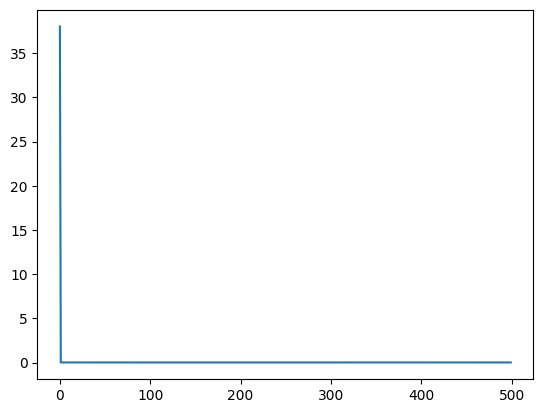

In [21]:
%matplotlib inline
plt.figure()
plt.plot(fixed_point_residual)
plt.show()

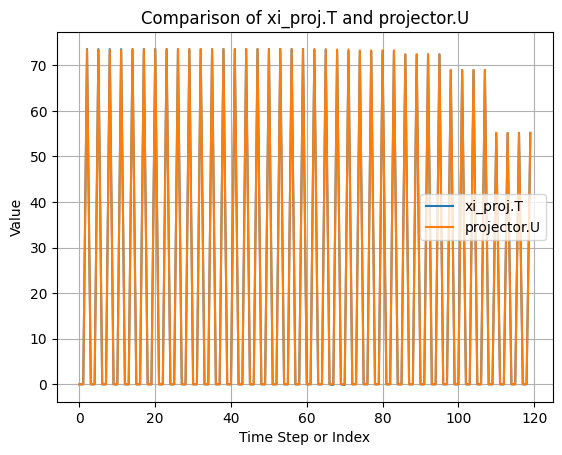

In [22]:
%matplotlib inline
plt.figure()
plt.plot(xi_proj.T, label="xi_proj.T")
plt.plot(projector.U, label="projector.U")
plt.legend()
plt.title("Comparison of xi_proj.T and projector.U")
plt.xlabel("Time Step or Index")
plt.ylabel("Value")
plt.grid(True)
plt.show()

In [23]:
print("\nBatched Quadruped QP projection complete!")

print("Check default Qp solvers")
print("U", projector.U.shape)
print("U", -projector.U[:12])



Batched Quadruped QP projection complete!
Check default Qp solvers
U (120,)
U [ 3.84543743e-13  3.55480985e-08 -7.33667975e+01 -3.22198809e-12
  3.55488122e-08 -7.33667975e+01  2.49918366e-12  3.50761855e-08
 -7.33667973e+01  4.17192694e-13  3.50813213e-08 -7.33667973e+01]


In [24]:

#Difference between Clarable and Our Own Augmented Lagrangian solver
print("Difference between Clarable and Our Own Augmented Lagrangian solver")
diff = projector.U.reshape(xi_proj.shape[0],xi_proj.shape[1])-xi_proj
print("xi_proj", xi_proj.shape)
print("Differnce", diff.shape)
print("Max difference", diff.max())    
print("Min difference", diff.min()) 

# Find the index of the max and min elements
max_idx = np.unravel_index(np.argmax(diff), diff.shape)
min_idx = np.unravel_index(np.argmin(diff), diff.shape)

# Print values and their locations
print("Max difference:", diff[max_idx], "at index", max_idx)
print("Min difference:", diff[min_idx], "at index", min_idx)   

Difference between Clarable and Our Own Augmented Lagrangian solver
xi_proj (1, 120)
Differnce (1, 120)
Max difference 0.348114
Min difference -0.20394135
Max difference: 0.348114 at index (np.int64(0), np.int64(68))
Min difference: -0.20394135 at index (np.int64(0), np.int64(2))
